In [1]:
%matplotlib inline
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import importlib
from PIL import Image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gc
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

import neural_net

## Load and transform data

In [2]:
transform = transforms.Compose([transforms.Resize(size=(32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_batch_size = 4
trainset = torchvision.datasets.STL10(root='.', split='train', download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=train_batch_size,
                                          shuffle=True, num_workers=4)

In [4]:
test_batch_size = 4
testset = torchvision.datasets.STL10(root='.', split='test', download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=test_batch_size,
                                         shuffle=False, num_workers=4)

In [5]:
unlabeled_batch_size = 4
unlabeled_set = torchvision.datasets.STL10(root='.', split='unlabeled', download=False, transform=transform)
unlabeledloader = torch.utils.data.DataLoader(unlabeled_set,
                                              batch_size=unlabeled_batch_size,
                                              shuffle=True, num_workers=4)

In [6]:
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

In [7]:
def check_accuracy(net):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    return correct / total

In [8]:
def check_accuracy_on_classes(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [9]:
def train_net(net, dataset, dataloader, optimizer, criterion, batch_size=4, num_of_epochs=10, print_progress=True,
          freq_of_printing=1.):
    num_of_batches_to_print = len(dataset) / batch_size * freq_of_printing
    accuracy = []
    time_elapsed = []
    losses = []
    
    accumulated_time = 0
    for epoch in range(num_of_epochs):  # loop over the dataset multiple times
        running_loss = 0.0    
        start = time.time()
        for i, data in enumerate(dataloader, 0):
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            if print_progress and i % num_of_batches_to_print == num_of_batches_to_print - 1:
                accumulated_time += time.time() - start
                time_elapsed.append(accumulated_time)
                accuracy.append(check_accuracy(net))
                losses.append(running_loss / num_of_batches_to_print)
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                      (epoch + 1, i + 1, running_loss / num_of_batches_to_print, accuracy[-1]))

                running_loss = 0.0

    print('Finished Training')
    return accuracy, time_elapsed, losses

In [10]:
def imshow(img_real, img_processed):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    img_real = img_real / 2 + 0.5 #  unnormalize
    img_processed = img_processed / 2 + 0.5
    npimg_real = img_real.numpy()
    npimg_processed = img_processed.numpy()
    npimg_real[npimg_real < 0] = 0
    npimg_real[npimg_real > 1] = 1
    npimg_processed[npimg_processed < 0] = 0
    npimg_processed[npimg_processed > 1] = 1
    ax1.imshow(np.transpose(npimg_real, (1, 2, 0)))
    ax2.imshow(np.transpose(npimg_processed, (1, 2, 0)))

## Train logistic regression

In [12]:
importlib.reload(neural_net)
logreg = neural_net.LinearNet()
optimizer = optim.SGD(logreg.parameters(), lr=0.01, weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss()

In [13]:
train_net(logreg, trainset, trainloader, optimizer, criterion,
          freq_of_printing=1, num_of_epochs=30, print_progress=True)
pass

[1,  1250] loss: 2.206, accuracy: 0.303
[2,  1250] loss: 1.970, accuracy: 0.316
[3,  1250] loss: 1.864, accuracy: 0.333
[4,  1250] loss: 1.793, accuracy: 0.299
[5,  1250] loss: 1.717, accuracy: 0.312
[6,  1250] loss: 1.662, accuracy: 0.325
[7,  1250] loss: 1.604, accuracy: 0.331
[8,  1250] loss: 1.571, accuracy: 0.319
[9,  1250] loss: 1.529, accuracy: 0.343
[10,  1250] loss: 1.495, accuracy: 0.330
[11,  1250] loss: 1.451, accuracy: 0.325
[12,  1250] loss: 1.447, accuracy: 0.319
[13,  1250] loss: 1.400, accuracy: 0.323
[14,  1250] loss: 1.376, accuracy: 0.337
[15,  1250] loss: 1.362, accuracy: 0.334
[16,  1250] loss: 1.339, accuracy: 0.329
[17,  1250] loss: 1.324, accuracy: 0.338
[18,  1250] loss: 1.291, accuracy: 0.329
[19,  1250] loss: 1.276, accuracy: 0.339
[20,  1250] loss: 1.260, accuracy: 0.332
[21,  1250] loss: 1.233, accuracy: 0.322
[22,  1250] loss: 1.231, accuracy: 0.331
[23,  1250] loss: 1.210, accuracy: 0.337
[24,  1250] loss: 1.196, accuracy: 0.324
[25,  1250] loss: 1.183, 

## Train random forrest

In [14]:
rf_trainloader = torch.utils.data.DataLoader(trainset,
                                             batch_size=len(trainset),
                                             shuffle=False, num_workers=1)
rf_testloader = torch.utils.data.DataLoader(testset,
                                            batch_size=len(testset),
                                            shuffle=False, num_workers=1)

In [15]:
dataiter = iter(rf_trainloader)
X_train = dataiter.next()[0].numpy().ravel().reshape(len(trainset), -1)
X_train.shape

(5000, 3072)

In [16]:
dataiter = iter(rf_testloader)
X_test = dataiter.next()[0].numpy().ravel().reshape(len(testset), -1)
X_test.shape

(8000, 3072)

In [17]:
y_train = trainset.labels
y_test = testset.labels

In [19]:
random_forrest = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
random_forrest.fit(X_train, y_train)
pass

In [20]:
y_pred = random_forrest.predict(X_test)

In [21]:
np.mean(y_pred == y_test)

0.43874999999999997

## Train convolutional net

#### check dependence of conv kernel size

In [13]:
importlib.reload(neural_net)
criterion = nn.CrossEntropyLoss()

In [27]:
linear_layer_input = [384, 96, 24, 24]
accuracy = []
time_elapsed = []
loss = []

for i, conv_kernel_size in enumerate(range(2, 9, 2)):
    print('conv_kernel_size: ', conv_kernel_size, '\n')
    conv_net_1 = neural_net.ConvNet(num_of_conv_layers=1, conv_kernel_size=(conv_kernel_size,),
                                    conv_stride=(conv_kernel_size,),
                                    linear_layer_input=linear_layer_input[i])
    optimizer = optim.SGD(conv_net_1.parameters(), lr=0.01, weight_decay=1e-5)
    acc, tim, los = train_net(conv_net_1, trainset, trainloader, optimizer, criterion,
                         freq_of_printing=1, num_of_epochs=40, print_progress=True)
    accuracy.append(acc)
    time_elapsed.append(tim)
    loss.append(los)

conv_kernel_size:  2 

[1,  1250] loss: 2.039, accuracy: 0.339
[2,  1250] loss: 1.799, accuracy: 0.375
[3,  1250] loss: 1.680, accuracy: 0.404
[4,  1250] loss: 1.589, accuracy: 0.425
[5,  1250] loss: 1.516, accuracy: 0.442
[6,  1250] loss: 1.455, accuracy: 0.457
[7,  1250] loss: 1.403, accuracy: 0.465
[8,  1250] loss: 1.352, accuracy: 0.464
[9,  1250] loss: 1.310, accuracy: 0.471
[10,  1250] loss: 1.265, accuracy: 0.468
[11,  1250] loss: 1.222, accuracy: 0.472
[12,  1250] loss: 1.186, accuracy: 0.473
[13,  1250] loss: 1.151, accuracy: 0.482
[14,  1250] loss: 1.107, accuracy: 0.481
[15,  1250] loss: 1.073, accuracy: 0.493
[16,  1250] loss: 1.036, accuracy: 0.485
[17,  1250] loss: 0.997, accuracy: 0.482
[18,  1250] loss: 0.957, accuracy: 0.488
[19,  1250] loss: 0.919, accuracy: 0.480
[20,  1250] loss: 0.887, accuracy: 0.478
[21,  1250] loss: 0.852, accuracy: 0.488
[22,  1250] loss: 0.817, accuracy: 0.482
[23,  1250] loss: 0.781, accuracy: 0.474
[24,  1250] loss: 0.749, accuracy: 0.482
[2

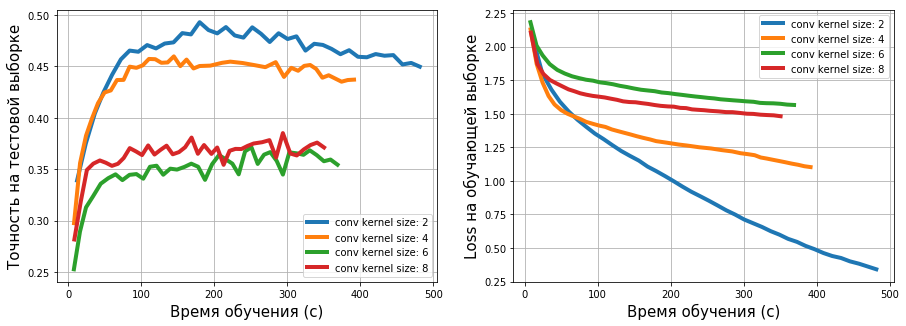

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

conv_kernel_sizes = [2, 4, 6, 8]
for time_, acc_, los_, kernel_size in zip(time_elapsed, accuracy, loss, conv_kernel_sizes):
    ax1.plot(time_, acc_, label='conv kernel size: ' + str(kernel_size), linewidth=4)
    ax2.plot(time_, los_, label='conv kernel size: ' + str(kernel_size), linewidth=4)
ax1.grid()
ax2.grid()

ax1.set_xlabel('Время обучения (с)', fontsize=15)
ax2.set_xlabel('Время обучения (с)', fontsize=15)
ax1.set_ylabel('Точность на тестовой выборке', fontsize=15)
ax2.set_ylabel('Loss на обучающей выборке', fontsize=15)

ax1.legend()
ax2.legend()
plt.savefig('report/exp1.pdf', bbox_inches='tight')

#### check dependence on number of filters on conv layer

In [14]:
accuracy = []
time_elapsed = []
loss = []

for num_of_conv_units in range(5, 45, 5):
    print('num of conv units: ', num_of_conv_units, '\n')
    conv_net_1 = neural_net.ConvNet(num_of_conv_layers=1, conv_out_channels=(num_of_conv_units,),
                                    linear_layer_input=384 // 6 * num_of_conv_units)
    optimizer = optim.SGD(conv_net_1.parameters(), lr=0.01, weight_decay=1e-5)
    acc, tim, los = train_net(conv_net_1, trainset, trainloader, optimizer, criterion,
                              freq_of_printing=1, num_of_epochs=30, print_progress=True)
    accuracy.append(acc)
    time_elapsed.append(tim)
    loss.append(los)

num of conv units:  5 

[1,  1250] loss: 2.000, accuracy: 0.341
[2,  1250] loss: 1.746, accuracy: 0.394
[3,  1250] loss: 1.623, accuracy: 0.413
[4,  1250] loss: 1.540, accuracy: 0.427
[5,  1250] loss: 1.478, accuracy: 0.447
[6,  1250] loss: 1.423, accuracy: 0.445
[7,  1250] loss: 1.377, accuracy: 0.464
[8,  1250] loss: 1.335, accuracy: 0.469
[9,  1250] loss: 1.294, accuracy: 0.474
[10,  1250] loss: 1.256, accuracy: 0.474
[11,  1250] loss: 1.221, accuracy: 0.483
[12,  1250] loss: 1.186, accuracy: 0.475
[13,  1250] loss: 1.153, accuracy: 0.478
[14,  1250] loss: 1.119, accuracy: 0.483
[15,  1250] loss: 1.089, accuracy: 0.484
[16,  1250] loss: 1.056, accuracy: 0.472
[17,  1250] loss: 1.029, accuracy: 0.479
[18,  1250] loss: 0.999, accuracy: 0.481
[19,  1250] loss: 0.965, accuracy: 0.476
[20,  1250] loss: 0.939, accuracy: 0.475
[21,  1250] loss: 0.912, accuracy: 0.476
[22,  1250] loss: 0.882, accuracy: 0.465
[23,  1250] loss: 0.854, accuracy: 0.464
[24,  1250] loss: 0.832, accuracy: 0.467
[

[16,  1250] loss: 0.604, accuracy: 0.510
[17,  1250] loss: 0.553, accuracy: 0.503
[18,  1250] loss: 0.488, accuracy: 0.512
[19,  1250] loss: 0.445, accuracy: 0.500
[20,  1250] loss: 0.398, accuracy: 0.499
[21,  1250] loss: 0.356, accuracy: 0.496
[22,  1250] loss: 0.308, accuracy: 0.502
[23,  1250] loss: 0.277, accuracy: 0.504
[24,  1250] loss: 0.242, accuracy: 0.497
[25,  1250] loss: 0.211, accuracy: 0.500
[26,  1250] loss: 0.180, accuracy: 0.502
[27,  1250] loss: 0.154, accuracy: 0.496
[28,  1250] loss: 0.134, accuracy: 0.498
[29,  1250] loss: 0.118, accuracy: 0.495
[30,  1250] loss: 0.101, accuracy: 0.497
Finished Training
num of conv units:  40 

[1,  1250] loss: 1.871, accuracy: 0.373
[2,  1250] loss: 1.627, accuracy: 0.431
[3,  1250] loss: 1.491, accuracy: 0.458
[4,  1250] loss: 1.380, accuracy: 0.472
[5,  1250] loss: 1.283, accuracy: 0.495
[6,  1250] loss: 1.201, accuracy: 0.513
[7,  1250] loss: 1.118, accuracy: 0.508
[8,  1250] loss: 1.037, accuracy: 0.510
[9,  1250] loss: 0.974

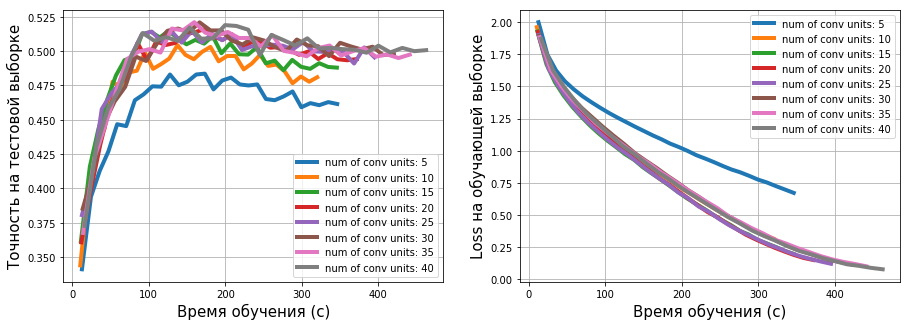

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

num_of_conv_units = list(range(5, 45, 5))
for time_, acc_, los_, conv_units in zip(time_elapsed, accuracy, loss, num_of_conv_units):
    ax1.plot(time_, acc_, label='num of conv units: ' + str(conv_units), linewidth=4)
    ax2.plot(time_, los_, label='num of conv units: ' + str(conv_units), linewidth=4)
ax1.grid()
ax2.grid()

ax1.set_xlabel('Время обучения (с)', fontsize=15)
ax2.set_xlabel('Время обучения (с)', fontsize=15)
ax1.set_ylabel('Точность на тестовой выборке', fontsize=15)
ax2.set_ylabel('Loss на обучающей выборке', fontsize=15)

ax1.legend()
ax2.legend()
plt.savefig('report/exp2.pdf', bbox_inches='tight')

#### check dependence on num of conv layers

In [23]:
importlib.reload(neural_net)

params = {
    'conv_out_channels': (30, 20, 10),
    'conv_kernel_size': (2, 2, 2),
    'conv_stride': (2, 1, 1),
    'pool_kernel_size': (2, 2, 2),
    'pool_stride': (2, 1, 1),
}

linear_layer_input = [1920, 720, 160]
accuracy = []
time_elapsed = []
loss = []

for i in range(3):
    conv_net = neural_net.ConvNet(num_of_conv_layers=i + 1, linear_layer_input=linear_layer_input[i], **params)
    optimizer = optim.SGD(conv_net.parameters(), lr=0.01, weight_decay=1e-5)
    acc, tim, los = train_net(conv_net, trainset, trainloader, optimizer, criterion,
                              freq_of_printing=1, num_of_epochs=50, print_progress=True)
    accuracy.append(acc)
    time_elapsed.append(tim)
    loss.append(los)

[1,  1250] loss: 1.903, accuracy: 0.367
[2,  1250] loss: 1.646, accuracy: 0.414
[3,  1250] loss: 1.507, accuracy: 0.463
[4,  1250] loss: 1.395, accuracy: 0.468
[5,  1250] loss: 1.306, accuracy: 0.484
[6,  1250] loss: 1.229, accuracy: 0.497
[7,  1250] loss: 1.155, accuracy: 0.512
[8,  1250] loss: 1.089, accuracy: 0.501
[9,  1250] loss: 1.028, accuracy: 0.501
[10,  1250] loss: 0.967, accuracy: 0.500
[11,  1250] loss: 0.902, accuracy: 0.503
[12,  1250] loss: 0.847, accuracy: 0.524
[13,  1250] loss: 0.790, accuracy: 0.514
[14,  1250] loss: 0.728, accuracy: 0.517
[15,  1250] loss: 0.672, accuracy: 0.508
[16,  1250] loss: 0.617, accuracy: 0.512
[17,  1250] loss: 0.561, accuracy: 0.511
[18,  1250] loss: 0.507, accuracy: 0.508
[19,  1250] loss: 0.461, accuracy: 0.502
[20,  1250] loss: 0.413, accuracy: 0.507
[21,  1250] loss: 0.367, accuracy: 0.501
[22,  1250] loss: 0.326, accuracy: 0.504
[23,  1250] loss: 0.284, accuracy: 0.501
[24,  1250] loss: 0.249, accuracy: 0.501
[25,  1250] loss: 0.220, 

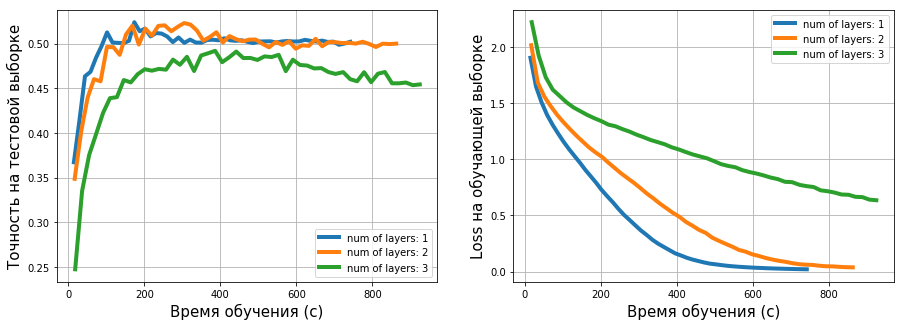

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for i, (time_, acc_, los_) in enumerate(zip(time_elapsed, accuracy, loss)):
    ax1.plot(time_, acc_, label='num of layers: ' + str(i + 1), linewidth=4)
    ax2.plot(time_, los_, label='num of layers: ' + str(i + 1), linewidth=4)
ax1.grid()
ax2.grid()

ax1.set_xlabel('Время обучения (с)', fontsize=15)
ax2.set_xlabel('Время обучения (с)', fontsize=15)
ax1.set_ylabel('Точность на тестовой выборке', fontsize=15)
ax2.set_ylabel('Loss на обучающей выборке', fontsize=15)

ax1.legend()
ax2.legend()
plt.savefig('report/exp3.pdf', bbox_inches='tight')

#### ckeck dependence on using momentum

In [30]:
importlib.reload(neural_net)

momentum = [0, 0.1, 0.5, 0.9]
accuracy_1 = []
time_elapsed_1 = []
loss_1 = []
accuracy_2 = []
time_elapsed_2 = []
loss_2 = []

for i, momentum_coef in enumerate(momentum):
    conv_net = neural_net.ConvNet(num_of_conv_layers=1)
    optimizer = optim.SGD(conv_net.parameters(), lr=0.01, momentum=momentum_coef, weight_decay=1e-5)
    acc, tim, los = train_net(conv_net, trainset, trainloader, optimizer, criterion,
                              freq_of_printing=1, num_of_epochs=30, print_progress=True)
    accuracy_1.append(acc)
    time_elapsed_1.append(tim)
    loss_1.append(los)

    conv_net = neural_net.ConvNet(num_of_conv_layers=1)
    optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=momentum_coef, weight_decay=1e-5)
    acc, tim, los = train_net(conv_net, trainset, trainloader, optimizer, criterion,
                              freq_of_printing=1, num_of_epochs=30, print_progress=True)
    accuracy_2.append(acc)
    time_elapsed_2.append(tim)
    loss_2.append(los)

[1,  1250] loss: 1.852, accuracy: 0.390
[2,  1250] loss: 1.609, accuracy: 0.430
[3,  1250] loss: 1.470, accuracy: 0.457
[4,  1250] loss: 1.364, accuracy: 0.471
[5,  1250] loss: 1.268, accuracy: 0.507
[6,  1250] loss: 1.183, accuracy: 0.496
[7,  1250] loss: 1.101, accuracy: 0.504
[8,  1250] loss: 1.026, accuracy: 0.521
[9,  1250] loss: 0.954, accuracy: 0.523
[10,  1250] loss: 0.883, accuracy: 0.521
[11,  1250] loss: 0.815, accuracy: 0.518
[12,  1250] loss: 0.733, accuracy: 0.518
[13,  1250] loss: 0.660, accuracy: 0.526
[14,  1250] loss: 0.591, accuracy: 0.508
[15,  1250] loss: 0.517, accuracy: 0.517
[16,  1250] loss: 0.449, accuracy: 0.518
[17,  1250] loss: 0.388, accuracy: 0.518
[18,  1250] loss: 0.322, accuracy: 0.515
[19,  1250] loss: 0.273, accuracy: 0.515
[20,  1250] loss: 0.226, accuracy: 0.515
[21,  1250] loss: 0.188, accuracy: 0.522
[22,  1250] loss: 0.151, accuracy: 0.517
[23,  1250] loss: 0.124, accuracy: 0.515
[24,  1250] loss: 0.101, accuracy: 0.518
[25,  1250] loss: 0.083, 

[20,  1250] loss: 1.486, accuracy: 0.423
[21,  1250] loss: 1.490, accuracy: 0.422
[22,  1250] loss: 1.424, accuracy: 0.431
[23,  1250] loss: 1.389, accuracy: 0.424
[24,  1250] loss: 1.387, accuracy: 0.433
[25,  1250] loss: 1.367, accuracy: 0.383
[26,  1250] loss: 1.396, accuracy: 0.438
[27,  1250] loss: 1.396, accuracy: 0.422
[28,  1250] loss: 1.361, accuracy: 0.421
[29,  1250] loss: 1.389, accuracy: 0.443
[30,  1250] loss: 1.370, accuracy: 0.450
Finished Training
[1,  1250] loss: 1.867, accuracy: 0.360
[2,  1250] loss: 1.619, accuracy: 0.433
[3,  1250] loss: 1.488, accuracy: 0.459
[4,  1250] loss: 1.392, accuracy: 0.476
[5,  1250] loss: 1.300, accuracy: 0.489
[6,  1250] loss: 1.215, accuracy: 0.491
[7,  1250] loss: 1.137, accuracy: 0.514
[8,  1250] loss: 1.056, accuracy: 0.524
[9,  1250] loss: 0.974, accuracy: 0.514
[10,  1250] loss: 0.900, accuracy: 0.521
[11,  1250] loss: 0.827, accuracy: 0.524
[12,  1250] loss: 0.757, accuracy: 0.520
[13,  1250] loss: 0.678, accuracy: 0.521
[14,  1

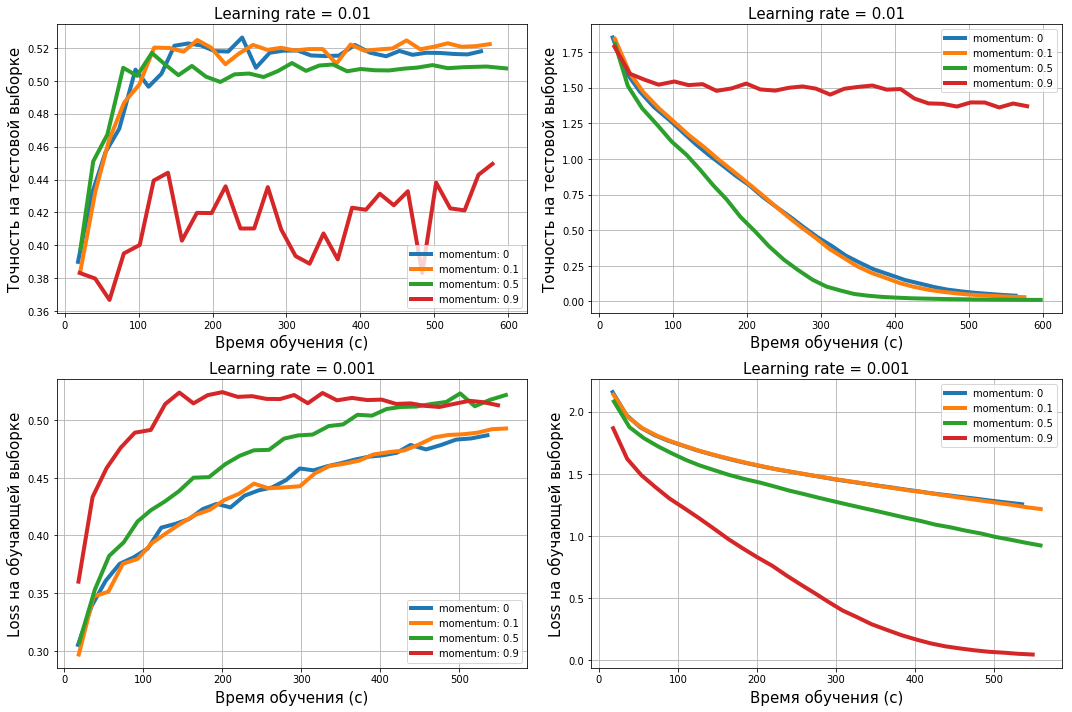

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,10))

for time_1, acc_1, los_1, time_2, acc_2, los_2, momentum_coef in zip(time_elapsed_1, accuracy_1, loss_1,
                                                                     time_elapsed_2, accuracy_2, loss_2, momentum):
    ax1[0].plot(time_1, acc_1, label='momentum: ' + str(momentum_coef), linewidth=4)
    ax1[1].plot(time_1, los_1, label='momentum: ' + str(momentum_coef), linewidth=4)
    ax2[0].plot(time_2, acc_2, label='momentum: ' + str(momentum_coef), linewidth=4)
    ax2[1].plot(time_2, los_2, label='momentum: ' + str(momentum_coef), linewidth=4)

for i in range(2):
    ax1[i].set_title('Learning rate = 0.01', fontsize=15)
    ax2[i].set_title('Learning rate = 0.001', fontsize=15)
    ax1[i].set_xlabel('Время обучения (с)', fontsize=15)
    ax2[i].set_xlabel('Время обучения (с)', fontsize=15)
    ax1[i].set_ylabel('Точность на тестовой выборке', fontsize=15)
    ax2[i].set_ylabel('Loss на обучающей выборке', fontsize=15)
    ax1[i].grid()
    ax2[i].grid()
    ax1[i].legend()
    ax2[i].legend()

plt.tight_layout()
plt.savefig('report/exp4.pdf', bbox_inches='tight')

## Train autoencoder

In [11]:
autoencoder_criterion = nn.MSELoss()
autoencoder = neural_net.ConvAutoEncoder()

In [12]:
imshow_batch_size = 5
imshowloader = torch.utils.data.DataLoader(trainset, batch_size=imshow_batch_size,
                                           shuffle=True, num_workers=1)

In [13]:
def check_mse(net):
    total_mse = 0.
    for data in testloader:
        inputs = Variable(data[0])
        outputs = net(inputs)
        total_mse += autoencoder_criterion(outputs, inputs).data[0]
    return total_mse * test_batch_size / len(testset)

In [14]:
def train_autoencoder(net, dataset, dataloader, batch_size=4, num_of_epochs=1, print_freq=1.):
    num_of_batches_to_print = len(dataset) / batch_size * print_freq

    for epoch in range(num_of_epochs):  # loop over the dataset multiple times
        running_loss = 0.0   
        for i, data in enumerate(dataloader, 0):
            # get the inputs
            inputs = data[0]
            # wrap them in Variable
            inputs = Variable(inputs)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = autoencoder(inputs)
            loss = autoencoder_criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            if i % num_of_batches_to_print == num_of_batches_to_print - 1:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f, mse on test: %.3f' %
                      (epoch + 1, i + 1, running_loss / num_of_batches_to_print, check_mse(autoencoder)))
                running_loss = 0.0

    print('Finished Training')

In [15]:
def check_images():
    dataiter = iter(imshowloader)
    images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images), torchvision.utils.make_grid(autoencoder(Variable(images)).data))

In [19]:
importlib.reload(neural_net)
autoencoder = neural_net.ConvAutoEncoder()
dataiter = iter(trainloader)
images, labels = dataiter.next()
autoencoder(Variable(images))
autoencoder.inter_layer_size

torch.Size([4, 40, 8, 8])

In [20]:
importlib.reload(neural_net)

autoencoder = neural_net.ConvAutoEncoder()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, weight_decay=1e-5)
train_autoencoder(autoencoder, unlabeled_set, unlabeledloader,
                  batch_size=train_batch_size, num_of_epochs=2, print_freq=0.05)

[1,  1250] loss: 0.198, mse on test: 0.162
[1,  2500] loss: 0.158, mse on test: 0.147
[1,  3750] loss: 0.152, mse on test: 0.144
[1,  5000] loss: 0.149, mse on test: 0.142
[1,  6250] loss: 0.146, mse on test: 0.140
[1,  7500] loss: 0.145, mse on test: 0.139
[1,  8750] loss: 0.142, mse on test: 0.137
[1, 10000] loss: 0.143, mse on test: 0.136
[1, 11250] loss: 0.141, mse on test: 0.135
[1, 12500] loss: 0.139, mse on test: 0.133
[1, 13750] loss: 0.137, mse on test: 0.132
[1, 15000] loss: 0.138, mse on test: 0.131
[1, 16250] loss: 0.136, mse on test: 0.130
[1, 17500] loss: 0.135, mse on test: 0.129
[1, 18750] loss: 0.135, mse on test: 0.128
[1, 20000] loss: 0.133, mse on test: 0.128
[1, 21250] loss: 0.133, mse on test: 0.127
[1, 22500] loss: 0.131, mse on test: 0.126
[1, 23750] loss: 0.130, mse on test: 0.125
[1, 25000] loss: 0.128, mse on test: 0.124
[2,  1250] loss: 0.129, mse on test: 0.124
[2,  2500] loss: 0.127, mse on test: 0.123
[2,  3750] loss: 0.129, mse on test: 0.122
[2,  5000] 

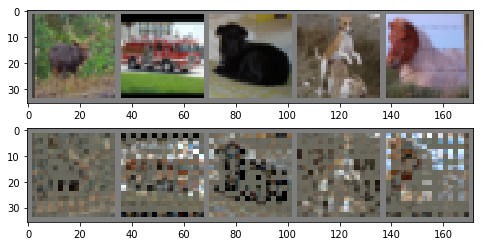

In [21]:
check_images()

In [22]:
importlib.reload(neural_net)
params = {
    'conv_kernel_size': 3,
    'conv_stride': 2,
    'conv_padding': 1,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'pool_padding': 0
}
autoencoder = neural_net.ConvAutoEncoder(**params)
dataiter = iter(trainloader)
images, labels = dataiter.next()
autoencoder(Variable(images))
autoencoder.inter_layer_size

torch.Size([4, 40, 8, 8])

In [23]:
importlib.reload(neural_net)

autoencoder = neural_net.ConvAutoEncoder(**params)
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, weight_decay=1e-5)
train_autoencoder(autoencoder, unlabeled_set, unlabeledloader,
                  batch_size=train_batch_size, num_of_epochs=2, print_freq=0.05)

[1,  1250] loss: 0.172, mse on test: 0.114
[1,  2500] loss: 0.110, mse on test: 0.103
[1,  3750] loss: 0.104, mse on test: 0.098
[1,  5000] loss: 0.099, mse on test: 0.095
[1,  6250] loss: 0.096, mse on test: 0.091
[1,  7500] loss: 0.093, mse on test: 0.089
[1,  8750] loss: 0.090, mse on test: 0.086
[1, 10000] loss: 0.089, mse on test: 0.084
[1, 11250] loss: 0.086, mse on test: 0.083
[1, 12500] loss: 0.086, mse on test: 0.081
[1, 13750] loss: 0.083, mse on test: 0.080
[1, 15000] loss: 0.082, mse on test: 0.078
[1, 16250] loss: 0.081, mse on test: 0.077
[1, 17500] loss: 0.080, mse on test: 0.076
[1, 18750] loss: 0.078, mse on test: 0.075
[1, 20000] loss: 0.078, mse on test: 0.075
[1, 21250] loss: 0.077, mse on test: 0.074
[1, 22500] loss: 0.077, mse on test: 0.073
[1, 23750] loss: 0.075, mse on test: 0.072
[1, 25000] loss: 0.075, mse on test: 0.072
[2,  1250] loss: 0.075, mse on test: 0.071
[2,  2500] loss: 0.074, mse on test: 0.071
[2,  3750] loss: 0.073, mse on test: 0.070
[2,  5000] 

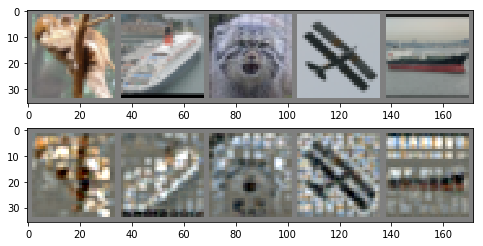

In [24]:
check_images()

In [25]:
importlib.reload(neural_net)
params = {
    'conv_kernel_size': 6,
    'conv_stride': 2,
    'conv_padding': 1,
    'pool_kernel_size': 3,
    'pool_stride': 2,
    'pool_padding': 1
}
autoencoder = neural_net.ConvAutoEncoder(**params)
dataiter = iter(trainloader)
images, labels = dataiter.next()
autoencoder(Variable(images))
autoencoder.inter_layer_size

torch.Size([4, 40, 8, 8])

In [26]:
importlib.reload(neural_net)

autoencoder = neural_net.ConvAutoEncoder(**params)
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, weight_decay=1e-5)
train_autoencoder(autoencoder, unlabeled_set, unlabeledloader,
                  batch_size=train_batch_size, num_of_epochs=2, print_freq=0.05)

[1,  1250] loss: 0.128, mse on test: 0.082
[1,  2500] loss: 0.078, mse on test: 0.069
[1,  3750] loss: 0.066, mse on test: 0.060
[1,  5000] loss: 0.057, mse on test: 0.053
[1,  6250] loss: 0.052, mse on test: 0.049
[1,  7500] loss: 0.048, mse on test: 0.045
[1,  8750] loss: 0.045, mse on test: 0.043
[1, 10000] loss: 0.043, mse on test: 0.041
[1, 11250] loss: 0.041, mse on test: 0.039
[1, 12500] loss: 0.039, mse on test: 0.038
[1, 13750] loss: 0.038, mse on test: 0.037
[1, 15000] loss: 0.037, mse on test: 0.036
[1, 16250] loss: 0.036, mse on test: 0.035
[1, 17500] loss: 0.035, mse on test: 0.034
[1, 18750] loss: 0.035, mse on test: 0.034
[1, 20000] loss: 0.034, mse on test: 0.033
[1, 21250] loss: 0.033, mse on test: 0.033
[1, 22500] loss: 0.033, mse on test: 0.032
[1, 23750] loss: 0.033, mse on test: 0.032
[1, 25000] loss: 0.032, mse on test: 0.031
[2,  1250] loss: 0.031, mse on test: 0.031
[2,  2500] loss: 0.031, mse on test: 0.030
[2,  3750] loss: 0.031, mse on test: 0.030
[2,  5000] 

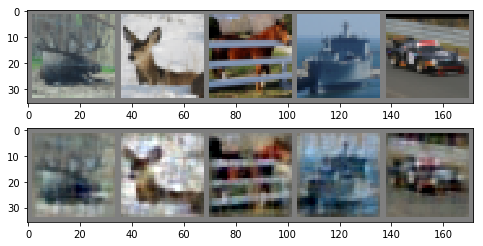

In [27]:
check_images()

In [28]:
importlib.reload(neural_net)
params = {
    'conv_kernel_size': 5,
    'conv_stride': 2,
    'conv_padding': 2,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'pool_padding': 0,
}
autoencoder = neural_net.ConvAutoEncoder(**params)
dataiter = iter(trainloader)
images, labels = dataiter.next()
autoencoder(Variable(images))
autoencoder.inter_layer_size

torch.Size([4, 40, 8, 8])

In [29]:
importlib.reload(neural_net)

autoencoder = neural_net.ConvAutoEncoder(**params)
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, weight_decay=1e-5)
train_autoencoder(autoencoder, unlabeled_set, unlabeledloader,
                  batch_size=train_batch_size, num_of_epochs=2, print_freq=0.05)

[1,  1250] loss: 0.125, mse on test: 0.071
[1,  2500] loss: 0.067, mse on test: 0.059
[1,  3750] loss: 0.056, mse on test: 0.051
[1,  5000] loss: 0.048, mse on test: 0.044
[1,  6250] loss: 0.043, mse on test: 0.040
[1,  7500] loss: 0.039, mse on test: 0.037
[1,  8750] loss: 0.037, mse on test: 0.035
[1, 10000] loss: 0.035, mse on test: 0.033
[1, 11250] loss: 0.034, mse on test: 0.032
[1, 12500] loss: 0.032, mse on test: 0.031
[1, 13750] loss: 0.031, mse on test: 0.030
[1, 15000] loss: 0.030, mse on test: 0.029
[1, 16250] loss: 0.029, mse on test: 0.028
[1, 17500] loss: 0.029, mse on test: 0.028
[1, 18750] loss: 0.028, mse on test: 0.027
[1, 20000] loss: 0.027, mse on test: 0.027
[1, 21250] loss: 0.027, mse on test: 0.026
[1, 22500] loss: 0.027, mse on test: 0.026
[1, 23750] loss: 0.026, mse on test: 0.026
[1, 25000] loss: 0.026, mse on test: 0.025
[2,  1250] loss: 0.026, mse on test: 0.025
[2,  2500] loss: 0.025, mse on test: 0.025
[2,  3750] loss: 0.025, mse on test: 0.024
[2,  5000] 

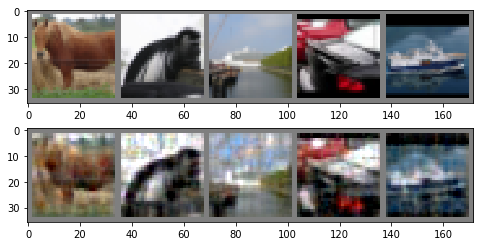

In [30]:
check_images()
plt.savefig('report/exp5.pdf', bbox_inches='tight')

## Train logreg with new features

In [31]:
def train_net_with_encoder(net, encoder, dataset, dataloader, optimizer, criterion, batch_size=4, num_of_epochs=10,
                           print_progress=True, freq_of_printing=1.):
    num_of_batches_to_print = len(dataset) / batch_size * freq_of_printing
    accuracy = []
    time_elapsed = []
    losses = []
    
    accumulated_time = 0
    for epoch in range(num_of_epochs):  # loop over the dataset multiple times
        running_loss = 0.0    
        start = time.time()
        for i, data in enumerate(dataloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = encoder(Variable(inputs))
            # wrap them in Variable
            inputs, labels = Variable(inputs.data), Variable(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            if print_progress and i % num_of_batches_to_print == num_of_batches_to_print - 1:
                accumulated_time += time.time() - start
                time_elapsed.append(accumulated_time)
                accuracy.append(check_accuracy_with_encoder(net, encoder))
                losses.append(running_loss / num_of_batches_to_print)
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                      (epoch + 1, i + 1, running_loss / num_of_batches_to_print, accuracy[-1]))

                running_loss = 0.0

    print('Finished Training')
    return accuracy, time_elapsed, losses

In [32]:
def check_accuracy_with_encoder(net, encoder):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images = encoder(Variable(images)).data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    return correct / total

In [33]:
importlib.reload(neural_net)
encoder = neural_net.Encoder(autoencoder)
logreg = neural_net.LinearNet(input_size=40 * 8 * 8)
optimizer = optim.SGD(logreg.parameters(), lr=0.01, weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss()

In [34]:
train_net_with_encoder(logreg, encoder, trainset, trainloader, optimizer, criterion,
                       freq_of_printing=1, num_of_epochs=30, print_progress=True)
pass

[1,  1250] loss: 1.878, accuracy: 0.378
[2,  1250] loss: 1.575, accuracy: 0.421
[3,  1250] loss: 1.451, accuracy: 0.419
[4,  1250] loss: 1.364, accuracy: 0.417
[5,  1250] loss: 1.299, accuracy: 0.456
[6,  1250] loss: 1.231, accuracy: 0.446
[7,  1250] loss: 1.185, accuracy: 0.481
[8,  1250] loss: 1.146, accuracy: 0.468
[9,  1250] loss: 1.100, accuracy: 0.465
[10,  1250] loss: 1.068, accuracy: 0.471
[11,  1250] loss: 1.035, accuracy: 0.455
[12,  1250] loss: 1.008, accuracy: 0.478
[13,  1250] loss: 0.980, accuracy: 0.452
[14,  1250] loss: 0.953, accuracy: 0.485
[15,  1250] loss: 0.934, accuracy: 0.490
[16,  1250] loss: 0.911, accuracy: 0.468
[17,  1250] loss: 0.889, accuracy: 0.473
[18,  1250] loss: 0.866, accuracy: 0.479
[19,  1250] loss: 0.854, accuracy: 0.470
[20,  1250] loss: 0.837, accuracy: 0.485
[21,  1250] loss: 0.821, accuracy: 0.473
[22,  1250] loss: 0.801, accuracy: 0.478
[23,  1250] loss: 0.790, accuracy: 0.475
[24,  1250] loss: 0.771, accuracy: 0.496
[25,  1250] loss: 0.754, 

## Train random forrest with new features

In [35]:
rf_trainloader = torch.utils.data.DataLoader(trainset,
                                             batch_size=len(trainset),
                                             shuffle=False, num_workers=1)
rf_testloader = torch.utils.data.DataLoader(testset,
                                            batch_size=len(testset),
                                            shuffle=False, num_workers=1)

In [36]:
dataiter = iter(rf_trainloader)
input_data = dataiter.next()[0]
output_data = encoder(Variable(input_data)).data
X_train = output_data.numpy().ravel().reshape(len(trainset), -1)
X_train.shape

(5000, 2560)

In [37]:
dataiter = iter(rf_testloader)
input_data = dataiter.next()[0]
output_data = encoder(Variable(input_data)).data
X_test = output_data.numpy().ravel().reshape(len(testset), -1)
X_test.shape

(8000, 2560)

In [38]:
y_train = trainset.labels
y_test = testset.labels

In [39]:
random_forrest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
random_forrest.fit(X_train, y_train)
pass

In [40]:
y_pred = random_forrest.predict(X_test)

In [41]:
np.mean(y_pred == y_test)

0.47399999999999998

## Retrain conv net with autoencoder initialization

In [60]:
importlib.reload(neural_net)
conv_net = neural_net.ConvNet()
conv_net.encoder = nn.Sequential(
    autoencoder.conv,
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
optimizer = optim.SGD(conv_net.parameters(), lr=0.01, weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss()

In [61]:
train_net(conv_net, trainset, trainloader, optimizer, criterion,
          freq_of_printing=1, num_of_epochs=40, print_progress=True)
pass

[1,  1250] loss: 1.787, accuracy: 0.419
[2,  1250] loss: 1.484, accuracy: 0.474
[3,  1250] loss: 1.345, accuracy: 0.494
[4,  1250] loss: 1.227, accuracy: 0.496
[5,  1250] loss: 1.120, accuracy: 0.515
[6,  1250] loss: 1.010, accuracy: 0.514
[7,  1250] loss: 0.915, accuracy: 0.517
[8,  1250] loss: 0.802, accuracy: 0.527
[9,  1250] loss: 0.705, accuracy: 0.519
[10,  1250] loss: 0.602, accuracy: 0.535
[11,  1250] loss: 0.491, accuracy: 0.531
[12,  1250] loss: 0.394, accuracy: 0.524
[13,  1250] loss: 0.310, accuracy: 0.519
[14,  1250] loss: 0.234, accuracy: 0.524
[15,  1250] loss: 0.175, accuracy: 0.527
[16,  1250] loss: 0.131, accuracy: 0.531
[17,  1250] loss: 0.096, accuracy: 0.536
[18,  1250] loss: 0.072, accuracy: 0.534
[19,  1250] loss: 0.058, accuracy: 0.532
[20,  1250] loss: 0.047, accuracy: 0.536
[21,  1250] loss: 0.039, accuracy: 0.535
[22,  1250] loss: 0.033, accuracy: 0.534
[23,  1250] loss: 0.029, accuracy: 0.536
[24,  1250] loss: 0.025, accuracy: 0.534
[25,  1250] loss: 0.023, 